# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Airline delays**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [37]:
bucket = '<your_s3_bucket_name_here>'
prefix = 'sagemaker/DEMO-xgboost-churn'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [39]:
region = boto3.Session().region_name
bucket='sci6-ebsc0-2018-08-20' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker/DEMO-xgboost-customer_churn'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

In [40]:
role = get_execution_role()
data_key = 'FlightSchedule.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
churn = pd.read_csv(data_location)
pd.set_option('display.max_columns', 500)

### Data conversion
Remove unwanted columns

In [41]:
churn.dropna(subset=["DEP_DELAY"], how = 'all', inplace = True)

In [42]:
churn['CLASSIFIED_DELAY'] = np.sign(churn["DEP_DELAY"])
churn.dropna(subset=["CLASSIFIED_DELAY"], how='all', inplace = True)
churn['Churn?'] = np.where((churn['CLASSIFIED_DELAY'] > churn['CLASSIFIED_DELAY'].median()), 1, 0)
churn = churn.drop("DEP_DELAY", axis = 1)
churn = churn.drop("Unnamed: 13", axis = 1)


In [43]:
churn = churn.drop("CLASSIFIED_DELAY", axis = 1)
churn = churn.dropna(axis = 0, how ='any') 
churn = churn.set_index('Churn?').reset_index()

col_0,% observations
ORIGIN,
ABE,0.000618
ABI,0.000304
ABQ,0.002062
ABR,0.000076
ABY,0.000067
ACT,0.000067
ACV,0.000466
ACY,0.000314
ADK,0.000010


,Churn?,YEAR,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEP_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,105222.000000,105222.0,105222.000000,105222.000000,1.052220e+05,105222.000000,105222.000000,105222.000000,105222.000000,105222.000000,105222.000000,105222.000000
mean,0.873658,2019.0,31734.143734,12705.332069,1.270537e+06,31777.167512,1480.360894,20.106080,4.428551,18.508392,0.079508,24.950590
std,0.332236,0.0,1257.496664,1487.521488,1.487520e+05,1273.718476,492.495236,65.762202,38.535323,41.726392,3.203342,50.851973
min,0.000000,2019.0,30070.000000,10135.000000,1.013505e+06,30070.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2019.0,30792.000000,11298.000000,1.129806e+06,30785.000000,1120.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2019.0,31453.000000,12892.000000,1.289208e+06,31603.000000,1528.000000,0.000000,0.000000,5.000000,0.000000,0.000000
75%,1.000000,2019.0,32467.000000,13930.000000,1.393007e+06,32467.000000,1858.000000,16.000000,0.000000,21.000000,0.000000,29.000000
max,1.000000,2019.0,35991.000000,16218.000000,1.621802e+06,35991.000000,2400.000000,1638.000000,1416.000000,1447.000000,816.000000,1514.000000


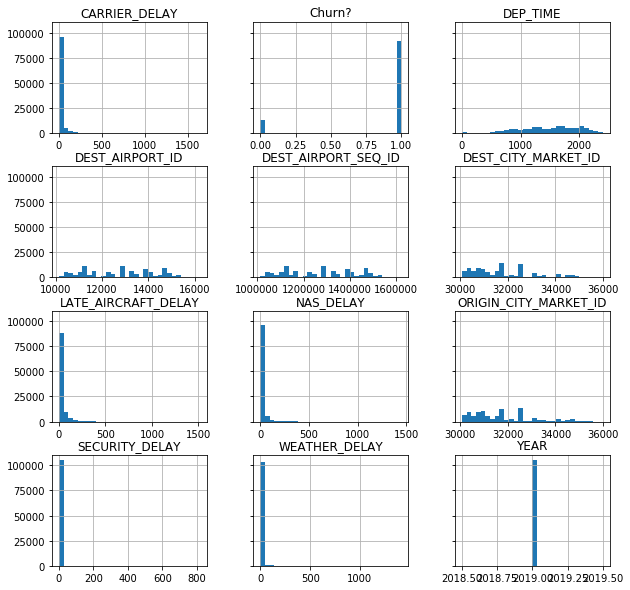

In [44]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [45]:
churn = churn.drop(['DEST_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_CITY_MARKET_ID', 'ORIGIN_CITY_MARKET_ID', 'YEAR'], axis=1)
churn['CARRIER_DELAY'] = np.where((churn['CARRIER_DELAY'] > churn['CARRIER_DELAY'].median()), 1, 0)
churn['WEATHER_DELAY'] = np.where((churn['WEATHER_DELAY'] > churn['WEATHER_DELAY'].median()), 1, 0)
churn['NAS_DELAY'] = np.where((churn['NAS_DELAY'] > churn['NAS_DELAY'].median()), 1, 0)
churn['SECURITY_DELAY'] = np.where((churn['SECURITY_DELAY'] > churn['SECURITY_DELAY'].median()), 1, 0)
churn['LATE_AIRCRAFT_DELAY'] = np.where((churn['LATE_AIRCRAFT_DELAY'] > churn['LATE_AIRCRAFT_DELAY'].median()), 1, 0)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [46]:
model_data = pd.get_dummies(churn)
#model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)
model_data

,Churn?,DEP_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_ABE,ORIGIN_ABI,ORIGIN_ABQ,ORIGIN_ABR,ORIGIN_ABY,ORIGIN_ACT,ORIGIN_ACV,ORIGIN_ACY,ORIGIN_ADK,ORIGIN_ADQ,ORIGIN_AEX,ORIGIN_AGS,ORIGIN_ALB,ORIGIN_ALO,ORIGIN_AMA,ORIGIN_ANC,ORIGIN_APN,ORIGIN_ART,ORIGIN_ASE,ORIGIN_ATL,ORIGIN_ATW,ORIGIN_AUS,ORIGIN_AVL,ORIGIN_AVP,ORIGIN_AZA,ORIGIN_AZO,ORIGIN_BDL,ORIGIN_BET,ORIGIN_BFF,ORIGIN_BFL,ORIGIN_BGM,ORIGIN_BGR,ORIGIN_BHM,ORIGIN_BIL,ORIGIN_BIS,ORIGIN_BJI,ORIGIN_BLI,ORIGIN_BLV,ORIGIN_BMI,ORIGIN_BNA,ORIGIN_BOI,ORIGIN_BOS,ORIGIN_BPT,ORIGIN_BQK,ORIGIN_BQN,ORIGIN_BRD,ORIGIN_BRO,ORIGIN_BRW,ORIGIN_BTM,ORIGIN_BTR,ORIGIN_BTV,ORIGIN_BUF,ORIGIN_BUR,ORIGIN_BWI,ORIGIN_BZN,ORIGIN_CAE,ORIGIN_CAK,ORIGIN_CDC,ORIGIN_CDV,ORIGIN_CGI,ORIGIN_CHA,ORIGIN_CHO,ORIGIN_CHS,ORIGIN_CID,ORIGIN_CIU,ORIGIN_CKB,ORIGIN_CLE,ORIGIN_CLL,ORIGIN_CLT,ORIGIN_CMH,ORIGIN_CMI,ORIGIN_CMX,ORIGIN_CNY,ORIGIN_COD,ORIGIN_COS,ORIGIN_COU,ORIGIN_CPR,ORIGIN_CRP,ORIGIN_CRW,ORIGIN_CSG,ORIGIN_CVG,ORIGIN_CWA,ORIGIN_CYS,ORIGIN_DAB,ORIGIN_DAL,ORIGIN_DAY,ORIGIN_DBQ,ORIGIN_DCA,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DHN,ORIGIN_DLH,ORIGIN_DRO,ORIGIN_DRT,ORIGIN_DSM,ORIGIN_DTW,ORIGIN_DVL,ORIGIN_EAR,ORIGIN_EAU,ORIGIN_ECP,ORIGIN_EGE,ORIGIN_EKO,ORIGIN_ELM,ORIGIN_ELP,ORIGIN_ERI,ORIGIN_ESC,ORIGIN_EUG,ORIGIN_EVV,ORIGIN_EWN,ORIGIN_EWR,ORIGIN_EYW,ORIGIN_FAI,ORIGIN_FAR,ORIGIN_FAT,ORIGIN_FAY,ORIGIN_FCA,ORIGIN_FLG,ORIGIN_FLL,ORIGIN_FNT,ORIGIN_FSD,ORIGIN_FSM,ORIGIN_FWA,ORIGIN_GCC,ORIGIN_GCK,ORIGIN_GEG,ORIGIN_GFK,ORIGIN_GGG,ORIGIN_GJT,ORIGIN_GNV,ORIGIN_GPT,ORIGIN_GRB,ORIGIN_GRI,ORIGIN_GRK,ORIGIN_GRR,ORIGIN_GSO,ORIGIN_GSP,ORIGIN_GTF,ORIGIN_GTR,ORIGIN_GUC,ORIGIN_GUM,ORIGIN_HDN,ORIGIN_HGR,ORIGIN_HHH,ORIGIN_HIB,ORIGIN_HLN,ORIGIN_HNL,ORIGIN_HOB,ORIGIN_HOU,ORIGIN_HPN,ORIGIN_HRL,ORIGIN_HSV,ORIGIN_HTS,ORIGIN_HVN,ORIGIN_HYS,ORIGIN_IAD,ORIGIN_IAG,ORIGIN_IAH,ORIGIN_ICT,ORIGIN_IDA,ORIGIN_ILM,ORIGIN_IMT,ORIGIN_IND,ORIGIN_INL,ORIGIN_ISN,ORIGIN_ISP,ORIGIN_ITH,ORIGIN_ITO,ORIGIN_JAC,ORIGIN_JAN,ORIGIN_JAX,ORIGIN_JFK,ORIGIN_JLN,ORIGIN_JMS,ORIGIN_JNU,ORIGIN_KOA,ORIGIN_KTN,ORIGIN_LAN,ORIGIN_LAR,ORIGIN_LAS,ORIGIN_LAW,ORIGIN_LAX,ORIGIN_LBB,ORIGIN_LBE,ORIGIN_LBF,ORIGIN_LBL,ORIGIN_LCH,ORIGIN_LCK,ORIGIN_LEX,ORIGIN_LFT,ORIGIN_LGA,ORIGIN_LGB,ORIGIN_LIH,ORIGIN_LIT,ORIGIN_LNK,ORIGIN_LRD,ORIGIN_LSE,ORIGIN_LWB,ORIGIN_LWS,ORIGIN_MAF,ORIGIN_MBS,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MDT,ORIGIN_MDW,ORIGIN_MEI,ORIGIN_MEM,ORIGIN_MFE,ORIGIN_MFR,ORIGIN_MGM,ORIGIN_MHK,ORIGIN_MHT,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MKG,ORIGIN_MLB,ORIGIN_MLI,ORIGIN_MLU,ORIGIN_MMH,ORIGIN_MOB,ORIGIN_MOT,ORIGIN_MQT,ORIGIN_MRY,ORIGIN_MSN,ORIGIN_MSO,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_MTJ,ORIGIN_MYR,ORIGIN_OAJ,ORIGIN_OAK,ORIGIN_OGD,ORIGIN_OGG,ORIGIN_OGS,ORIGIN_OKC,ORIGIN_OMA,ORIGIN_OME,ORIGIN_ONT,ORIGIN_ORD,ORIGIN_ORF,ORIGIN_ORH,ORIGIN_OTH,ORIGIN_OTZ,ORIGIN_OWB,ORIGIN_PAH,ORIGIN_PBG,ORIGIN_PBI,ORIGIN_PDX,ORIGIN_PGD,ORIGIN_PHF,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_PIA,ORIGIN_PIB,ORIGIN_PIE,ORIGIN_PIH,ORIGIN_PIT,ORIGIN_PLN,ORIGIN_PNS,ORIGIN_PRC,ORIGIN_PSC,ORIGIN_PSE,ORIGIN_PSG,ORIGIN_PSM,ORIGIN_PSP,ORIGIN_PUB,ORIGIN_PVD,ORIGIN_PVU,ORIGIN_PWM,ORIGIN_RAP,ORIGIN_RDD,ORIGIN_RDM,ORIGIN_RDU,ORIGIN_RFD,ORIGIN_RHI,ORIGIN_RIC,ORIGIN_RKS,ORIGIN_RNO,ORIGIN_ROA,ORIGIN_ROC,ORIGIN_ROW,ORIGIN_RST,ORIGIN_RSW,ORIGIN_SAF,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_SAV,ORIGIN_SBA,ORIGIN_SBN,ORIGIN_SBP,ORIGIN_SCC,ORIGIN_SCE,ORIGIN_SCK,ORIGIN_SDF,ORIGIN_SEA,ORIGIN_SFB,ORIGIN_SFO,ORIGIN_SGF,ORIGIN_SGU,ORIGIN_SHD,ORIGIN_SHV,ORIGIN_SIT,ORIGIN_SJC,ORIGIN_SJT,ORIGIN_SJU,ORIGIN_SLC,ORIGIN_SLN,ORIGIN_SMF,ORIGIN_SMX,ORIGIN_SNA,ORIGIN_SPI,ORIGIN_SPN,ORIGIN_SPS,ORIGIN_SRQ,ORIGIN_STC,ORIGIN_STL,ORIGIN_STS,ORIGIN_STT,ORIGIN_STX,ORIGIN_SUN,ORIGIN_SUX,ORIGIN_SWF,ORIGIN_SWO,ORIGIN_SYR,ORIGIN_TLH,ORIGIN_TOL,ORIGIN_TPA,ORIGIN_TRI,ORIGIN_TTN,ORIGIN_TUL,ORIGIN_TUS,ORIGIN_TVC,ORIGIN_TWF,ORIGIN_TXK,ORIGIN_TYR,ORIGIN_TYS,ORIGIN_UIN,ORIGIN_USA,ORIGIN_VEL,ORIGIN_VLD,ORIGIN_VPS,ORIGIN_WRG,ORIGIN_XNA,ORIGIN_YAK,ORIGIN_YUM
0,1,1934.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [47]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [48]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [49]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [50]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [51]:
sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost', repo_version='latest')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=10,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)


In [52]:
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 20)}

In [53]:
objective_metric_name = 'validation:auc'

In [54]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=3)

In [55]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

In [61]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

u'InProgress'

In [66]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

Reminder: the tuning job has not been completed.
9 training jobs have completed


In [33]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{u'CreationTime': datetime.datetime(2019, 8, 22, 18, 26, 5, tzinfo=tzlocal()),
 u'FinalHyperParameterTuningJobObjectiveMetric': {u'MetricName': u'validation:auc',
                                                  u'Value': 0.9626510143280029},
 u'ObjectiveStatus': u'Succeeded',
 u'TrainingEndTime': datetime.datetime(2019, 8, 22, 18, 29, 15, tzinfo=tzlocal()),
 u'TrainingJobArn': u'arn:aws:sagemaker:us-east-1:360629003875:training-job/xgboost-190822-1818-009-73bf6fc9',
 u'TrainingJobName': u'xgboost-190822-1818-009-73bf6fc9',
 u'TrainingJobStatus': u'Completed',
 u'TrainingStartTime': datetime.datetime(2019, 8, 22, 18, 28, 6, tzinfo=tzlocal()),
 u'TunedHyperParameters': {u'alpha': u'1.7761748778148605',
                           u'eta': u'0.9692492755928406',
                           u'max_depth': u'18',
                           u'min_child_weight': u'2.973737120866363'}}


# Done until here on 8-21-2019 04:39:00PM

### Fetch all results as DataFrame
We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [34]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 10
{'lowest': 0.9239320158958435, 'highest': 0.9626510143280029}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,eta,max_depth,min_child_weight
1,0.962651,69.0,2019-08-22 18:29:15+00:00,xgboost-190822-1818-009-73bf6fc9,Completed,2019-08-22 18:28:06+00:00,1.776175,0.969249,18.0,2.973737
2,0.962283,69.0,2019-08-22 18:29:05+00:00,xgboost-190822-1818-008-bdbe2c8f,Completed,2019-08-22 18:27:56+00:00,1.816175,0.969249,18.0,3.153737
3,0.962113,70.0,2019-08-22 18:28:51+00:00,xgboost-190822-1818-007-c7129545,Completed,2019-08-22 18:27:41+00:00,1.783704,0.599010,17.0,1.821096
0,0.961524,74.0,2019-08-22 18:32:25+00:00,xgboost-190822-1818-010-2813d683,Completed,2019-08-22 18:31:11+00:00,0.091605,0.606964,13.0,2.292585
9,0.961183,78.0,2019-08-22 18:22:07+00:00,xgboost-190822-1818-001-5dd8476b,Completed,2019-08-22 18:20:49+00:00,0.561800,0.342062,15.0,3.134050
4,0.961136,63.0,2019-08-22 18:25:57+00:00,xgboost-190822-1818-006-40c2ddbc,Completed,2019-08-22 18:24:54+00:00,2.000000,0.404877,15.0,5.791181
8,0.959376,56.0,2019-08-22 18:22:15+00:00,xgboost-190822-1818-002-dadba8d6,Completed,2019-08-22 18:21:19+00:00,0.384094,0.317238,9.0,1.541214
5,0.958906,68.0,2019-08-22 18:25:27+00:00,xgboost-190822-1818-005-e5ae1718,Completed,2019-08-22 18:24:19+00:00,0.078260,0.354584,8.0,6.191083
7,0.957556,56.0,2019-08-22 18:21:36+00:00,xgboost-190822-1818-003-958de591,Completed,2019-08-22 18:20:40+00:00,1.739022,0.765646,5.0,1.860391
6,0.923932,64.0,2019-08-22 18:25:10+00:00,xgboost-190822-1818-004-c88d7377,Completed,2019-08-22 18:24:06+00:00,0.213553,0.173187,1.0,7.511464


### See TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [35]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

### Analyze the correlation between objective metric and individual hyperparameters
Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For exmaple, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [36]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))